In [1]:
# Instalando o PySpark
!pip install pyspark

In [2]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

Explorando os dados


In [4]:
# O tamanho dos dados
print(f'Nº linhas:{dados.count()}',f'\nNº colunas:{len(dados.columns)}')

Nº linhas:49459 
Nº colunas:4


In [5]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [6]:
# Conteudo
# dados.head() não traz a estrutura desejada
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [7]:
# Apresentando alguns comentários ditos como negativo ou positivo.

print("Negativo")
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)

print("Positivo")
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [8]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [9]:
# Proporção dos comentários
# conseguimos perceber que nossos dados são balanceados.
import pyspark.sql.functions as f
from pyspark.sql.window import Window

conta_classe=dados.groupBy('sentiment').count()
conta_classe.withColumn("(%)", f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100, 2)).show()

+---------+-----+-----+
|sentiment|count|  (%)|
+---------+-----+-----+
|      pos|24694|49.93|
|      neg|24765|50.07|
+---------+-----+-----+



Limpeza e processamento de dados

In [10]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



Wordcloud

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
amostra = dados.select('text_pt').sample(fraction=0.1, seed=101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [13]:
wordcloud = WordCloud( background_color = 'white',
                                            width = 1000,
                                            height = 600,
                                            collocations = False,
                                            prefer_horizontal = 1).generate(str(tudo))

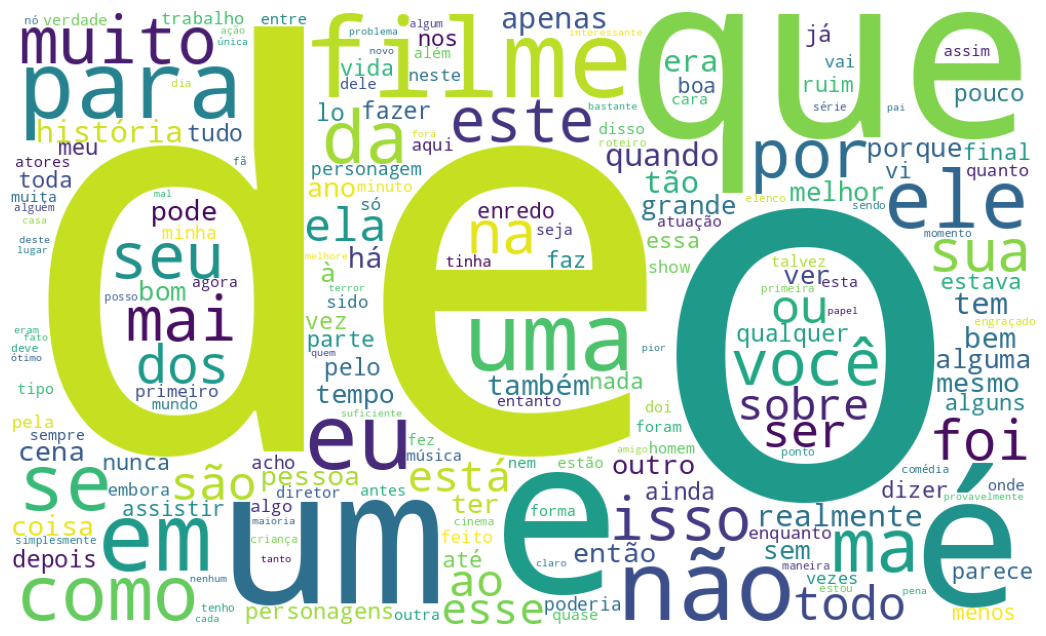

In [14]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Limpeza caracteres especiais

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [17]:
import pyspark.sql.functions as f

In [18]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

In [19]:
amostra.show(truncate=False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [20]:
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [21]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

In [22]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_pt", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

In [25]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Gerando Tokens

In [26]:
from pyspark.ml.feature import Tokenizer


In [27]:
tokenizer = Tokenizer(inputCol= "texto_limpo", outputCol= "tokens")
tokenizando = tokenizer.transform(dados)

In [28]:
tokenizando.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|
|Este é um exemplo...|[este, é, um, exe...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|
|Filmes de fotos d...|[filmes, de, foto...|
|Uma coisa engraça...|[uma, coisa, engr...|
|Este filme de ter...|[este, filme, de,...|
|Sendo um fã de lo...|[sendo, um, fã, d...|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|
|Fazendeiros ricos...|[fazendeiros, ric...|
|Cage interpreta u...|[cage, interpreta...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Então me diga  qu...|[então, me, diga,...|
|Uma grande decepç...|[uma, grande, dec...|
|Este filme é abso...|[este, filme, é, ...|
|Heres um decidida...|[heres, um, decid...|
|Na parte inferior...|[na, parte, infer...|
|A terra foi destr...|[a, terra, foi, d...|
|Muitas pessoas es...|[muitas, pessoas,...|
|A família de Nova...|[a, famíli

In [29]:
from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizando.select("texto_limpo", "tokens")\
.withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|        168|
|Este é um exemplo...|[este, é, um, exe...|        245|
|Primeiro de tudo ...|[primeiro, de, tu...|        213|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|        324|
|Filmes de fotos d...|[filmes, de, foto...|        244|
|Uma coisa engraça...|[uma, coisa, engr...|        116|
|Este filme de ter...|[este, filme, de,...|        161|
|Sendo um fã de lo...|[sendo, um, fã, d...|        146|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|        130|
|Fazendeiros ricos...|[fazendeiros, ric...|        167|
|Cage interpreta u...|[cage, interpreta...|        106|
|Primeiro de tudo ...|[primeiro, de, tu...|        315|
|Então me diga  qu...|[então, me, diga,...|        247|
|Uma grande decepç...|[uma, grande, dec...|        107|
|Este filme é abso...|[este, filme, é, ...|     

Stopwords

In [30]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [31]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
stop_A

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [33]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [34]:
stop_B

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [35]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

In [36]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_A)

df = remover.transform(tokenized)

df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [37]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B)

df = remover.transform(tokenized)

df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [38]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")

feature_data = remover.transform(tokenized)

In [39]:
feature_data.limit(11).show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                                    |
+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, não, ajuda, muito]              |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[o, mllib, spark, ajuda, e, é, fácil]          |
+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+



In [40]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[spark, é, ótimo,...|[spark, é, ótimo,...|          9|                9|
|[spark, mllib, nã...|[spark, mllib, nã...|          5|                5|
|[o, mllib, do, sp...|[o, mllib, spark,...|          8|                7|
+--------------------+--------------------+-----------+-----------------+



Bag of words

In [41]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")

In [42]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")
model = cv.fit(df)
df = model.transform(df)

In [43]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")

model = cv.fit(feature_data)

countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[spark, é, ótimo,...|(12,[0,1,3,4,8,9,...|
|[spark, mllib, nã...|(12,[0,2,5,6,10],...|
|[o, mllib, spark,...|(12,[0,1,2,3,4,5,...|
+--------------------+--------------------+



HashingTF

In [47]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HashingTF_e8e7ffa5159e

In [48]:
HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [49]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[spark, é, ótimo,...|(50,[0,3,11,18,36...|
|[spark, mllib, nã...|(50,[21,25,27,28,...|
|[o, mllib, spark,...|(50,[0,3,6,18,25,...|
+--------------------+--------------------+



TF-IDF

In [66]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol= "hashingTF", outputCol= "features")

idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [67]:
TFIDFfeaturizedData.select("texto_final", "features").limit(5).show(truncate= False)

+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|texto_final                                    |features                                                                                                                                             |
+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|(50,[0,3,11,18,36,39,42],[0.28768207245178085,0.5753641449035617,0.6931471805599453,0.28768207245178085,0.0,0.6931471805599453,0.6931471805599453])  |
|[spark, mllib, não, ajuda, muito]              |(50,[21,25,27,28,36],[0.6931471805599453,0.28768207245178085,0.6931471805599453,0.28768207245178085,0.0])                                            |


Pipeline de Transformação

In [59]:
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

In [63]:
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [64]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [68]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [69]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[mais, uma, vez, ...|(1000,[8,14,16,22...|(1000,[8,14,16,22...|
|  2|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|[este, é, um, exe...|(1000,[10,17,24,3...|(1000,[10,17,24,3...|
|  3|First of all I ha...|Primeiro de tudo ...|   

Árvore de decisao

In [70]:
featureDF = dados_transformados.select(['features', 'label'])

In [71]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [72]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [74]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

Amostra e treino

In [75]:
train,test = dados.randomSplit([0.7,0.3], seed=101)

In [76]:
df_model = pipeline.fit(train)

In [77]:
predictions = df_model.transform(test)

In [78]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Filmes de fotos d...|Filmes de fotos d...|  0.0|[filmes, de, foto...|[filmes, de, foto...|(1000,[7,9,12,24,...|(1000,[7,9,12,24,...|  [183.0,322.0]|[0.36237623762376...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

testes e métricas

In [79]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [81]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

acuracia = evaluator.evaluate(predictions)

In [83]:
print(f"Acuracia = %s", {acuracia})

Acuracia = %s {0.6449392712550607}
